### Two Body Simulation

A worksheet to simulate two spiraling black holes, using Post-Minkowski corrections to accounts for effects of relativity.

In [20]:
######
### This is the inital cell which prepares all of the necessary 
### packages and functions for use.
######

using Pkg
using DifferentialEquations
using Plots
using LSODA
using Roots

#This is a homemade package containing the differential equations used to calculate the Hamiltonian numerically.
Pkg.activate("HamiltonianFunctions")
using HamiltonianFunctions

@userplot TwoBodyPlot
@recipe function f(tb::TwoBodyPlot)
    m, x, y, z, xarray, yarray, zarray, negx, posx, negy, posy, negz, posz, r = tb.args
    n = r
    xlims --> (negx, posx)
    ylims --> (negy, posy)
    zlims --> (negz, posz)
    append!(xarray, x)
    append!(yarray, y)
    append!(zarray, z)
    if size(xarray)[1] > n
        deleteat!(xarray, 1)
        deleteat!(yarray, 1)
        deleteat!(zarray, 1)
    end
    linewidth --> range(0, m * 5, length = n)
    #seriesalpha --> range(0, 1, length = n)
    aspect_ratio --> 1
    label --> false
    xarray, yarray, zarray
end

function differentiate(q01, p01, q02, p02, q03, p03, q04, p04, q05, p05, tspan, c0, relativity)
    @time begin
        h01 = [0]
        q0 = collect(Base.Iterators.flatten([q01, q02]))
        p0 = collect(Base.Iterators.flatten([p01, p02]))
        
        #u0 = collect(Base.Iterators.flatten([q01, p01, q02, p02, q03, p03, q04, p04, q05, p05, h01]));
        #five bodies
        
        u0 = collect(Base.Iterators.flatten([q01, p01, q02, p02, h01]));
        #two bodies
        
        if relativity
            #prob = ODEProblem(HamiltonianFunctions.fiveBodyPM, u0, tspan, c0)
            #For five bodies
            
            prob = ODEProblem(HamiltonianFunctions.PM, u0, tspan, c0)
            #For two bodies
            
            #prob = HamiltonianProblem(HamiltonianFunctions.pmnbody, q0, p0, tspan, c0)
        else
            prob = ODEProblem(HamiltonianFunctions.Hamiltonian, u0, tspan, c0)
            #prob = HamiltonianProblem(HamiltonianFunctions.HNewtonian, q0, p0, tspan, c0)
        end
        
        #sol = solve(prob, KahanLi8(), dt=0.1, reltol = 1.0e-8, abstol = 1.0e-8, saveat = 100);
        #sol = solve(prob, RK4(), adaptive = true, reltol = 1.0e-8, abstol = 1.0e-8, saveat = 100);
        #sol = solve(prob, Rosenbrock23(), reltol = 1.0e-2, abstol = 1.0e-2, saveat = 100);
        #sol = solve(prob, Rodas5(), reltol = 1.0e-8, abstol = 1.0e-8, saveat = 100);
        #sol = solve(prob, lsoda(), reltol = 1.0e-12, abstol = 1.0e-12, saveat = 10);
        #sol = solve(prob, Tsit5(), reltol = 1.0e-8, abstol = 1.0e-8, saveat = 1000);
        #sol = solve(prob, ImplicitEuler(), reltol = 1.0e-5, abstol = 1.0e-5, saveat = 100);
        #sol = solve(prob, ERKN4(), reltol = 1.0e-8, abstol = 1.0e-8, saveat = 100);
        sol = DifferentialEquations.solve(prob, Vern9(), reltol = 1.0e-12, abstol = 1.0e-12, saveat = 10);
        
        #sol = solve(prob, SymplecticEuler(), reltol = 1.0e-9, abstol = 1.0e-9, saveat = 100, dt = 0.5); 
        ##Use this last one doing the HamiltonianProblem rather than just an ODEproblem
    end
    return sol, time
end

function differentiateEOB(r0, theta0, pr0, ptheta0, tspan, c0)
    @time begin
        h01 = [0.0]
        u0 = collect(Base.Iterators.flatten([r0, theta0, pr0, ptheta0, h01]))

        prob = ODEProblem(HamiltonianFunctions.EOB, u0, tspan, c0)
        sol = DifferentialEquations.solve(prob, lsoda(), reltol = 1.0e-9, abstol = 1.0e-9, saveat = 10)
    end
    return sol, time
end
    

 Activating environment at `~/Research/Post-Minkowski/notebooks/HamiltonianFunctions/Project.toml`


differentiateEOB (generic function with 1 method)

In [33]:
######
### This cell is for setting the parameters of the code. 
### These parameters are manually changed by the user as desired.
######

CSI = 3.00e8;
GSI = 6.647e-11;
MSUN = 1.989e30;

m1 = 2 * 1.576885748399201029384757; # Mass of the first body in solar masses
m2 = 1.576885748399201029384757; # Mass of the second body
m3 = 0.00000000005;
m4 = 0.00000000005;
m5 = 0.00000000005;

D = 6.0059968594837728919238347; # Initial separation of the first two bodies, in kilometers
ecc = 0.00000000000000; # eccentricity of the orbits
G = 1.0 / (16*pi); # Gravitational constant
C = 1.000000000000; #Speed of light
relativity = true; # A boolean value; if true, the code will apply Post-Minkowski relativistic corrections.
tspan = (0.0, 12000.0); # The amount of time for which the simulation runs

M = MSUN
L = (GSI / G) * M * (C / CSI)^2
T = L * (C / CSI)

pUnits = M * L / T
KEUnits = pUnits * L / T;

In [34]:
#####
### This cell defines a function to find initial conditions for a two
### body circular orbit using a solution derived from the Schaefer equations
#####

a16=D*D
a20(x)=x*x
a18=m1*m1
a27=m2*m2
a35=D^-2
a36(x)=a20(x)*a35
a19=a16*a18
a25(x)=a19+a20(x)
a28=a16*a27
a29(x)=a20(x)+a28
a37(x)=a18+a36(x)
a39(x)=a27+a36(x)
a46(x)=sqrt(a37(x))
a47(x)=sqrt(a39(x))
a50=m1^4
a51=m2^4
a67=D^4
schaeferFunc(x) = (1*(D^-5)*(-(a20(x)*a25(x)*a29(x)*(a46(x)+a47(x))*(a16^1.5))+G*(6*a18*a20(x)*a27*(a18+a27+2*a46(x)*a47(x))*(D^6)+a50*a51*(D^8)+(12*a27*a46(x)*a47(x)*a67+4*a50*a67+4*a51*a67+a18*(27*a27*a67+12*a46(x)*a47(x)*a67))*(x^4)+(18*a16*a18+18*a16*a27+12*a16*a46(x)*a47(x))*(x^6)+12*(x^8))))/(a25(x)*a29(x)*sqrt(a16)*sqrt(a37(x))*sqrt(a39(x)))



schaeferFunc (generic function with 1 method)

In [35]:
######
### This cell is where the code does most of its calculations. 
### If desired, a different ODE solver can also be chosen in this cell; 
### all that aren't currently being used are commented out. It will
### print out the changes in kinetic energy throughout the simulation in joules,
### and after each of those the ending kinetic energy divided by the initial,
### and then the distance between the bodies at the end of the simulation.
######

#Calculates factors based on eccentricity

if !(0 <= ecc <= 1)
    ecc = 0.0
end
qfac = 1.0 - ecc;
pfac = sqrt((1.0 + ecc)/(1.0 - ecc));

#Calculates inital position and momentum

totalM = m1 + m2
mu = m1 * m2 / (totalM)
newton_theta = sqrt(G * m1 * m2 * mu * D )

if relativity
    #Keep in mind this will be imaginary if they get too close, 
    #and consider that in first order, the PM solution has repulsive force if they get too close.
    p_theta = find_zero(schaeferFunc, (0, 2 * newton_theta))
else
    p_theta = newton_theta
end

x2 = D / (1 + (m1 / m2));
x1 = x2 - D;
py2 = p_theta / D;
println("Initial momentum is ", py2)
println("Corrected momentum is ", py2)
println()
py1 = -py2;

#Set up initial arrays for ODE problem

#c0 = [m1, m2, m3, m4, m5, G]
#five bodies

c0 = [m1, m2, G]

q01 = [x1 * qfac, 0.0]
p01 = [0.0, py1 * pfac]
q02 = [x2 * qfac, 0.0]
p02 = [0.0, py2 * pfac]

#2 dimensional

#=
q01 = [x1 * qfac, 0.0, 0.0]
p01 = [0.0, py1 * pfac, 0.0]
q02 = [x2 * qfac, 0.0, 0.0]
p02 = [0.0, py2 * pfac, 0.0]
=#
#3 dimensional

q03 = [0.0, 1.0, 0.000005]
p03 = [0.00000000000000005, 0.0, 0.0000000000000005]
q04 = [0.0, 0.0, 5.0]
p04 = [-0.000000000000000000005, 0.0, 0.0]
q05 = [0.0, 0.0, -5.0]
p05 = [0.000000000000000000005, 0.0, 0.0]

pi1, pi2 = sqrt((p01[1]^2) + (p01[2]^2)), sqrt((p02[1]^2) + (p02[2]^2));
KEi1, KEi2 = pi1^2 / (2 * m1), pi2^2 / (2 * m2);
initialKE1, initialKE2 = KEi1 * KEUnits, KEi2 * KEUnits

#Solve the equation
sol = differentiate(q01, p01, q02, p02, q03, p03, q04, p04, q05, p05, tspan, c0, relativity)[1]
solEOB = differentiateEOB(D, 0.0, 0.0, p_theta, tspan, c0)[1]
println()

rEOB = solEOB[1,:]
thetaEOB = solEOB[2,:]
lenEOB = size(solEOB[1,:])[1]
xEOB = zeros(lenEOB)
yEOB = zeros(lenEOB)

for i in 1:lenEOB
    xEOB[i] = rEOB[i] * cos(thetaEOB[i])
    yEOB[i] = rEOB[i] * sin(thetaEOB[i])
end

len = size(sol[1,:])[1]

xlist1 = sol[1,:]
ylist1 = sol[2,:]
zlist1 = zeros(len)
xlist2 = sol[5,:]
ylist2 = sol[6,:]
zlist2 = zeros(len)

momentumx1 = sol[3,:]
momentumy1 = sol[4,:]
momentumz1 = zeros(len)
momentumx2 = sol[7,:]
momentumy2 = sol[8,:]
momentumz2 = zeros(len)

#=
xlist1 = sol[1,:]
ylist1 = sol[2,:]
zlist1 = sol[3,:]
xlist2 = sol[7,:]
ylist2 = sol[8,:]
zlist2 = sol[9,:]

momentumx1 = sol[4,:]
momentumy1 = sol[5,:]
momentumz1 = sol[6,:]
momentumx2 = sol[10,:]
momentumy2 = sol[11,:]
momentumz2 = sol[12,:]
=#

#3 dimensional

#=
xlist3 = sol[13,:]
ylist3 = sol[14,:]
zlist3 = sol[15,:]
xlist4 = sol[19,:]
ylist4 = sol[20,:]
zlist4 = sol[21,:]
xlist5 = sol[25,:]
ylist5 = sol[26,:]
zlist5 = sol[27,:]
=#

#fivebodies

#Create an array that's just the value of the Hamiltonian. Comment this out for HamiltonianProblem.
hamilArr = sol[9,:];

#hamilArr = sol[31,:];
#five bodies

deleteat!(hamilArr, 1);


#Set an array that contains the distances between both bodies
xdis, ydis, zdis = xlist1 - xlist2, ylist1 - ylist2, zlist1 - zlist2
distArr = (xdis.^2 + ydis.^2 + zdis.^2).^0.5

pf1, pf2 = sqrt((momentumx1[len]^2) + (momentumy1[len]^2) + (momentumz1[len]^2)), sqrt((momentumx2[len]^2) + (momentumy2[len]^2) + (momentumz2[len]^2));
KEf1, KEf2 = pf1^2 / (2 * m1), pf2^2 / (2 * m2);
finalKE1, finalKE2 = KEf1 * KEUnits, KEf2 * KEUnits 
dKE1, dKE2 = finalKE1 - initialKE1, finalKE2 - initialKE2
xf, yf, zf = xlist1[len] - xlist2[len], ylist1[len] - ylist2[len], zlist1[len] - zlist2[len]
Df = sqrt(xf^2 + yf^2 + zf^2)
println("Change in KE of body 1 ", dKE1)
println("Ending KE of body 1 as a fraction of initial KE of body 1 ", KEf1/KEi1)
println()
println("Change in KE of body 2 ", dKE2)
println("Ending KE of body 2 as a fraction of initial KE of body 2 ", KEf2/KEi2)
println()
println("Final distance between objects ", Df, " = ", Df * L, " meters.")

Initial momentum is 0.13748017224416353
Corrected momentum is 0.13748017224416353

  0.023704 seconds (14.81 k allocations: 2.295 MiB)
  0.001194 seconds (5.66 k allocations: 699.297 KiB)

Change in KE of body 1 -1.2342385113539835e43
Ending KE of body 1 as a fraction of initial KE of body 1 0.9769907806078613

Change in KE of body 2 -2.468477022707967e43
Ending KE of body 2 as a fraction of initial KE of body 2 0.9769907806078613

Final distance between objects 6.076339494474826 = 448672.8995814462 meters.


In [36]:
######
### This cell creates plots that will be saved to the directory.
######

#Plot the Hamiltonian for error checking; this shouldn't change by much. Comment this out for HamiltonianProblem.

scatter(hamilArr)
savefig("hamiltonian.png")

#Plot the change in distance between the bodies over time

plot(distArr)
savefig("distance.png")

plot(rEOB)
savefig("distanceEOB.png")

#Plot the orbits of the bodies

plot(xlist1, ylist1, aspect_ratio = :equal)
plt = plot!(xlist2, ylist2, aspect_ratio = :equal)

# 2 dimensional

#=
plot(xlist1, ylist1, zlist1, aspect_ratio = :equal)
plt = plot!(xlist2, ylist2, zlist2, aspect_ratio = :equal)
=#

#=
plot!(xlist2, ylist2, zlist2, aspect_ratio = :equal)
plot!(xlist3, ylist3, zlist3, aspect_ratio = :equal)
plot!(xlist4, ylist4, zlist4, aspect_ratio = :equal)
plt = plot!(xlist5, ylist5, zlist5, aspect_ratio = :equal)
=#
#five bodies

savefig("orbits.png")

plot(xEOB, yEOB, aspect_ratio = :equal)
savefig("EOB.png")

┌ Info: Saved animation to 
│   fn = /Users/zackarywindham/Research/Post-Minkowski/notebooks/tmp.gif
└ @ Plots /Users/zackarywindham/.julia/packages/Plots/E3MWZ/src/animation.jl:104


Plots.AnimatedGif("/Users/zackarywindham/Research/Post-Minkowski/notebooks/tmp.gif")
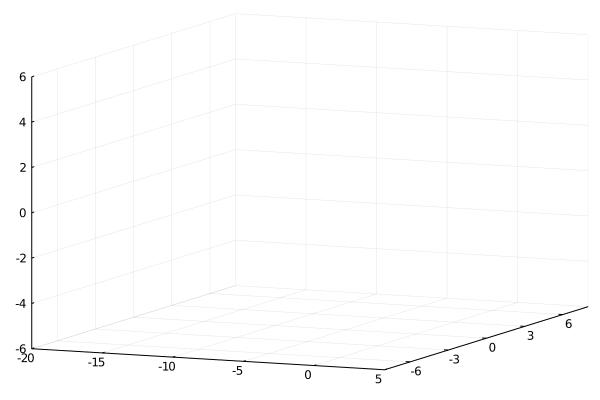

In [38]:
######
### If desired, this cell will animate the orbits of the bodies, 
### though the x and y bounds must be manually decided and inputted. 
######

xarr1, yarr1, zarr1, xarr2, yarr2, zarr2, xarr3, yarr3, zarr3, xarr4, yarr4, zarr4, xarr5, yarr5, zarr5 = [], [], [], [], [], [], [], [], [], [], [], [], [], [], []
xneg, xpos, yneg, ypos, zneg, zpos = -20, 5, -8, 8, -6, 6

r = m1 / m2
m10 = r / (1 + r)
m20 = 1 - m10


anim = @gif for i = 1:size(xlist1)[1]
    twobodyplot(m10, xlist1[i], ylist1[i], zlist1[i], xarr1, yarr1, zarr1, xneg, xpos, yneg, ypos, zneg, zpos, 100)
    twobodyplot!(m20, xlist2[i], ylist2[i], zlist2[i], xarr2, yarr2, zarr2, xneg, xpos, yneg, ypos, zneg, zpos, 100)
end every 10


#=
anim = @gif for i = 1:size(xlist1)[1]
    twobodyplot(m10, xlist1[i], ylist1[i], xarr1, yarr1, xneg, xpos, yneg, ypos, 100)
    twobodyplot!(m20, xlist2[i], ylist2[i], xarr2, yarr2, xneg, xpos, yneg, ypos, 100)
    twobodyplot!(m10, xlist3[i], ylist3[i], xarr3, yarr3, xneg, xpos, yneg, ypos, 100)
    twobodyplot!(m10, xlist4[i], ylist4[i], xarr4, yarr4, xneg, xpos, yneg, ypos, 100)
    twobodyplot!(m10, xlist5[i], ylist5[i], xarr5, yarr5, xneg, xpos, yneg, ypos, 100)
end every 5
=#

#=
anim = @gif for i = 1:size(xlist1)[1]
    twobodyplot(m10, xlist1[i], ylist1[i], zlist1[i], xarr1, yarr1, zarr1, xneg, xpos, yneg, ypos, zneg, zpos, 100)
    twobodyplot!(m20, xlist2[i], ylist2[i], zlist2[i], xarr2, yarr2, zarr2, xneg, xpos, yneg, ypos, zneg, zpos, 100)
    twobodyplot!(m20, xlist3[i], ylist3[i], zlist3[i], xarr3, yarr3, zarr3, xneg, xpos, yneg, ypos, zneg, zpos, 100)
    twobodyplot!(m20, xlist4[i], ylist4[i], zlist4[i], xarr4, yarr4, zarr4, xneg, xpos, yneg, ypos, zneg, zpos, 100)
    twobodyplot!(m20, xlist5[i], ylist5[i], zlist5[i], xarr5, yarr5, zarr5, xneg, xpos, yneg, ypos, zneg, zpos, 100)
end every 5
=#

#five bodies